# Mathematical symbol classification <br/>


## Part 1 - HoG feature
# Outline
1. Environment preparation
2. Load Data
3. Histogram-of-Oriented Gradient (HOG) feature extraction
4. Support Vector Machine (SVM) model training and evaluation
5. Artificial Neural Network (ANN) model training and evaluation
6. References

# 1. Environment preparation

In [1]:
# Import Numpy, Pandas, and Matplotlib for numeric computation, data processing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Scikit Learn
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Image processing and feature extraction
from skimage import feature
import cv2

# Directory and random variable generation
import os
import random
import csv

# Set for recproducibility
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2. Load Data

In [3]:
# Define training and test dataset paths
y_train_path = '/content/gdrive/MyDrive/42028/AT1/data/y_train_category.npy'
y_test_path = '/content/gdrive/MyDrive/42028/AT1/data/y_test_category.npy'
X_train_path = '/content/gdrive/MyDrive/42028/AT1/data/X_train.npy'
X_test_path = '/content/gdrive/MyDrive/42028/AT1/data/X_test.npy'

In [4]:
# Define DataLoader function
def DataLoader(y_train_path, y_test_path, X_train_path, X_test_path):
  '''
  This function reads the datasets from Google Drive and performs Label Encoding on y_train and y_test.
  '''
  # Load y_train and y_test
  y_train_category = np.load(y_train_path, allow_pickle=True)
  y_test_category = np.load(y_test_path, allow_pickle=True)

  # Define label encoder and fit
  le = LabelEncoder()
  le.fit(y_train_category)

  # Transform categories
  y_train = le.transform(y_train_category)
  y_test = le.transform(y_test_category)

  # create mapping of target classes
  mapping = dict(zip(le.classes_, range(len(le.classes_))))
  print(f"Mapping of Y: {mapping}")

  # Load X_train and X_test
  X_train = np.load(X_train_path)
  X_test = np.load(X_test_path)

  # Pring train and test data shape
  print(f"Training data shape: {X_train.shape}")
  print(f"Testing data shape: {X_test.shape}")

  return y_train, y_test, X_train, X_test

In [5]:
# Read dataset
y_train, y_test, X_train, X_test = DataLoader(y_train_path, y_test_path, X_train_path, X_test_path)

Mapping of Y: {'!': 0, '(': 1, '+': 2, 'beta': 3, 'cos': 4, 'log': 5, 'pi': 6, 'pm': 7, 'tan': 8, 'theta': 9}
Training data shape: (3500, 45, 45)
Testing data shape: (1500, 45, 45)


# 3. Histogram-of-Oriented Gradient (HoG) feature extraction

In [6]:
# The Function to compute the HoG feature
def compute_hog_features(images):
    # create an empty list
    hog_features = []
    # loop through images
    for image in images:
        # Compute HoG features using skimage
        features = feature.hog(image, orientations =9, pixels_per_cell=(10,10), cells_per_block=(2,2),
                               transform_sqrt=True, block_norm="L2-Hys")
        # append computed features to the empty list
        hog_features.append(features)
    # convert list to NumPy array
    return np.array(hog_features)

In [7]:
# Apply function on X_train data
X_train_hog = compute_hog_features(X_train)

In [8]:
# Apply function on X_test data
X_test_hog = compute_hog_features(X_test)

In [9]:
# Print shape of the extracted dataset
print(f"Train data shape: {np.shape(X_train_hog)}")
print(f"Test data shape: {np.shape(X_test_hog)}")

Train data shape: (3500, 324)
Test data shape: (1500, 324)


# 4. Support Vector Machine (SVM) model training and evaluation

## Parameter tuning

In [10]:
# import GridSearchCV from sklearn.model_selection for Parameter tuning
from sklearn.model_selection import GridSearchCV

In [11]:
# Parameter tuning function
def parameter_tuning(classifier_name, parameters):
  classifier = GridSearchCV(classifier_name, parameters)
  classifier.fit(X_train_hog, y_train)
  return print(f"Best params: {classifier.best_params_} and score: {classifier.best_score_:.4f}")

In [12]:
# Import SVC from sklearn.svm
from sklearn.svm import SVC
# Parameter dictionary
parameters_svc = {'C': [1, 50, 100], 'kernel':[ 'linear', 'poly', 'rbf']}
# Parameter tuning
parameter_tuning(SVC(), parameters_svc)

Best params: {'C': 1, 'kernel': 'poly'} and score: 0.9837


## Model training

In [13]:
# Fit X_train_hog and y_train with the best parameters
model_svm = SVC(C=1, kernel = 'poly', random_state=42)
model_svm.fit(X_train_hog, y_train)

SVC(C=1, kernel='poly', random_state=42)

In [14]:
# Train set accuracy
print("Train set accuracy SVC: {:.4f}".format(model_svm.score(X_train_hog, y_train)))

Train set accuracy SVC: 0.9980


## Model evaluation on test data

In [15]:
# Predict the X_test_hog data
y_pred_svm = model_svm.predict(X_test_hog)

In [16]:
# Test set accuracy
accuracy_svm =  metrics.accuracy_score(y_test, y_pred_svm)
print("Test set accuracy SVC: {:.4f}".format(accuracy_svm))

Test set accuracy SVC: 0.9833


In [17]:
# Create the labelNames list
labelNames = ['!', '(', '+', 'beta', 'cos', 'log', 'pi', 'pm', 'tan', 'theta']

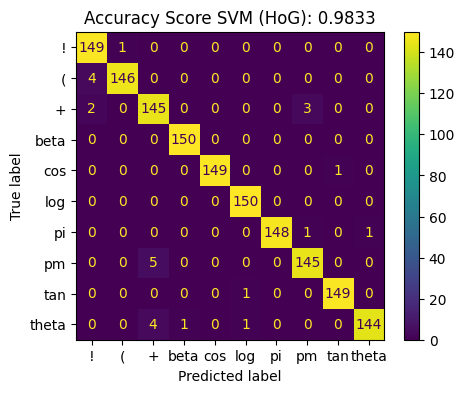

In [18]:
# Display the confusion matrix and import required package
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(figsize = (5,4), dpi = 100)
cm = confusion_matrix(y_test, y_pred_svm)
cmp = ConfusionMatrixDisplay(cm, display_labels = labelNames)
cmp.plot(ax=ax)
all_sample_title = 'Accuracy Score SVM (HoG): {:.4f}'.format(accuracy_svm)
plt.title(all_sample_title, size = 12);

In [19]:
# Display the evaluation report
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       0.99      0.97      0.98       150
           2       0.94      0.97      0.95       150
           3       0.99      1.00      1.00       150
           4       1.00      0.99      1.00       150
           5       0.99      1.00      0.99       150
           6       1.00      0.99      0.99       150
           7       0.97      0.97      0.97       150
           8       0.99      0.99      0.99       150
           9       0.99      0.96      0.98       150

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



## Visualize SVM results

In [20]:
def display_results_svm(image_indices):
  num_samples = X_test_hog[image_indices].shape[0]
  selected_features = X_test_hog[image_indices]
  selected_labels = [y_test[i] for i in image_indices]

  # Predict selected features
  predictions_svm = model_svm.predict(np.array(selected_features))

  # Select original images
  selected_original_images = [X_test[i] for i in image_indices]

  # Plot original images and display Actual label and Predicted label
  plt.figure(figsize=(15, 8))
  for i in range(8):
      plt.subplot(2, 4, i + 1)
      plt.imshow(selected_original_images[i], cmap='gray')
      plt.title("Predicted: {} vs Actual: {}".format(labelNames[predictions_svm[i]], labelNames[selected_labels[i]]))
      plt.axis('off')
  plt.show()

In [21]:
# Create indices
true_indices_svm = np.where(y_pred_svm == y_test)[0]
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]

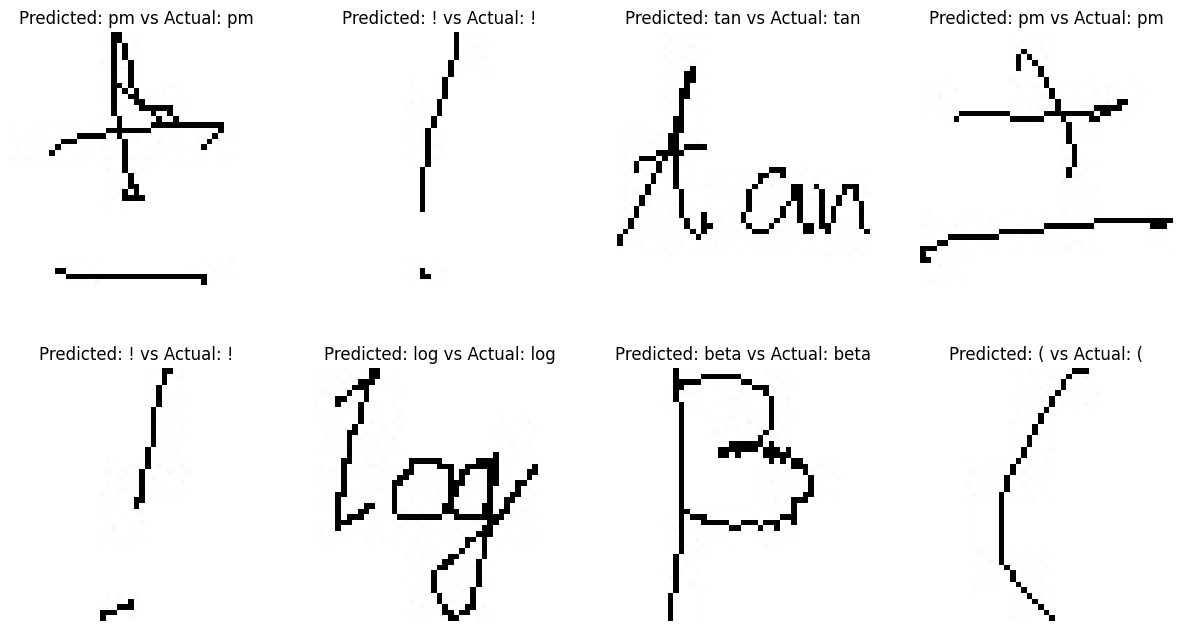

In [22]:
# Display true classified results
display_results_svm(true_indices_svm)

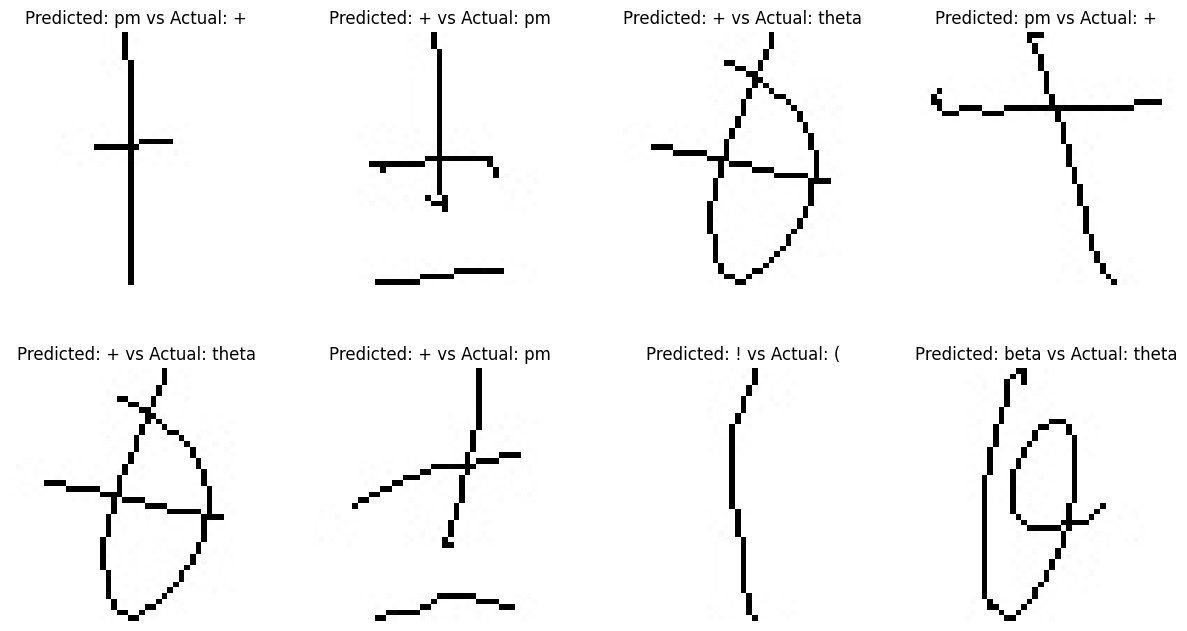

In [23]:
# Display  misclassified results
display_results_svm(misclassified_indices_svm)

# 5. Artificial Neural Network (ANN) model training and evaluation

In [24]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.15.0


In [25]:
# Seed TensorFlow
seed = 42
tf.random.set_seed(seed)

## Model training

In [26]:
# Define callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1):
      print("Early stopping Triggered")
      self.model.stop_training = True
callbacks = myCallback()

In [27]:
# Model architecture
model_ann = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(X_train_hog.shape[1],)),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Compile the model
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
History = model_ann.fit(X_train_hog, y_train, epochs=10, callbacks=[callbacks])

Epoch 1/10
110/110 [==============================] - 2s 4ms/step - loss: 1.1085 - accuracy: 0.7277
Epoch 2/10
110/110 [==============================] - 0s 4ms/step - loss: 0.2760 - accuracy: 0.9237
Epoch 3/10
110/110 [==============================] - 1s 5ms/step - loss: 0.1715 - accuracy: 0.9503
Epoch 4/10
110/110 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.9660
Epoch 5/10
110/110 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.9711
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.9771


In [28]:
model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               41600     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 59402 (232.04 KB)
Trainable params: 59402 (232.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


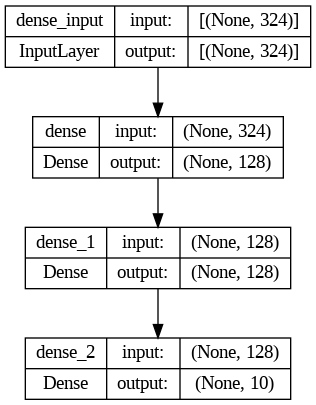

In [29]:
# Visualize ANN Model
modelViz_file= 'model_ann_hog.png'
keras.utils.plot_model(model_ann, to_file=modelViz_file, show_shapes=True)

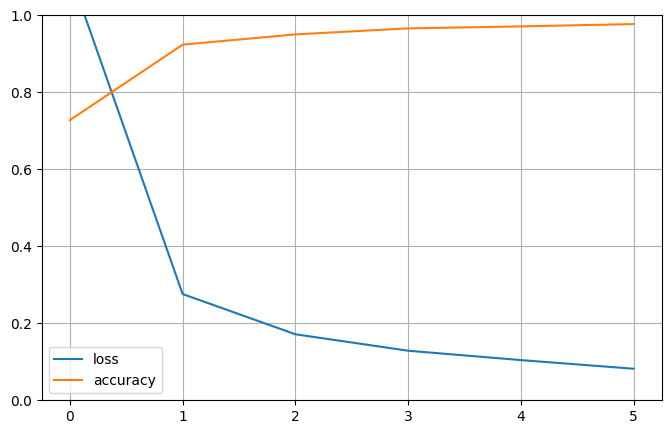

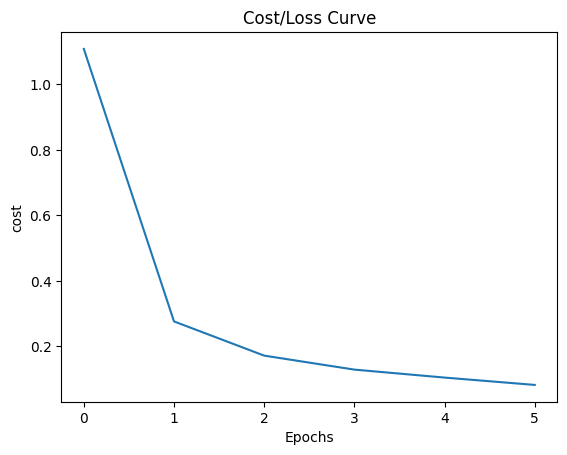

In [30]:
## Plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(History.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Plot only the loss train loss
plt.plot(History.history['loss'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.title("Cost/Loss Curve")
plt.show()

In [31]:
# Evaluate the model's performance on the training dataset.
model_ann.evaluate(X_train_hog, y_train)

110/110 [==============================] - 0s 2ms/step - loss: 0.0658 - accuracy: 0.9831


[0.0658428966999054, 0.9831428527832031]

## ANN evaluation on the test dataset

In [32]:
# Evaluate the model's performance on the test dataset.
model_ann.evaluate(X_test_hog, y_test)

47/47 [==============================] - 0s 2ms/step - loss: 0.1169 - accuracy: 0.9667


[0.11694876104593277, 0.9666666388511658]

In [33]:
# Predict X_test_hog
predict_ann = model_ann.predict(X_test_hog)

47/47 [==============================] - 0s 2ms/step


In [34]:
# Convert probabilities to labels
y_pred_ann = ((predict_ann > 0.5)*1).argmax(axis=1)
y_pred_ann

array([7, 0, 8, ..., 5, 8, 3])

In [35]:
# Compute accuracy
accuracy_ann =  metrics.accuracy_score(y_test, y_pred_ann)
print("Test data accuracy ANN: {:.4f}".format(accuracy_ann))

Test data accuracy ANN: 0.9607


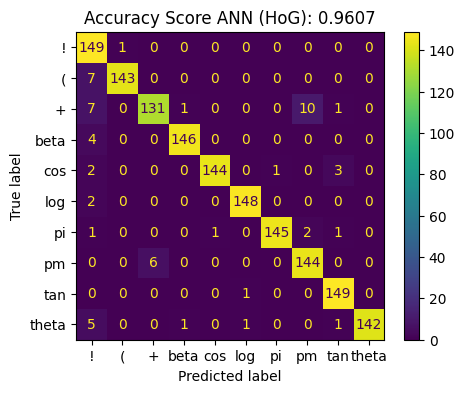

In [36]:
# Display the confusion matrix and import required package
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

fig, ax = plt.subplots(figsize = (5,4), dpi = 100)
cm = confusion_matrix(y_test, y_pred_ann)
cmp = ConfusionMatrixDisplay(cm, display_labels = labelNames)
cmp.plot(ax=ax)
all_sample_title = 'Accuracy Score ANN (HoG): {:.4f}'.format(accuracy_ann)
plt.title(all_sample_title, size = 12);

In [37]:
# Display the evaluation report
print(metrics.classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       150
           1       0.99      0.95      0.97       150
           2       0.96      0.87      0.91       150
           3       0.99      0.97      0.98       150
           4       0.99      0.96      0.98       150
           5       0.99      0.99      0.99       150
           6       0.99      0.97      0.98       150
           7       0.92      0.96      0.94       150
           8       0.96      0.99      0.98       150
           9       1.00      0.95      0.97       150

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



## Visualize ANN results

In [38]:
def display_results_ann(image_indices):
  num_samples = X_test_hog[image_indices].shape[0]
  selected_features = X_test_hog[image_indices]
  selected_labels = [y_test[i] for i in image_indices]

  # predict the selected features
  predictions_ann = model_ann.predict(np.array(selected_features))
  # Get class names from predictions
  y_pred_ann_display = ((predictions_ann > 0.5)*1).argmax(axis=1)

  # Select original images
  selected_original_images = [X_test[i] for i in image_indices]

  # plot results
  plt.figure(figsize=(15, 8))
  for i in range(8):
      plt.subplot(2, 4, i + 1)
      plt.imshow(selected_original_images[i], cmap='gray')
      plt.title("Predicted: {} vs Actual: {}".format(labelNames[y_pred_ann_display[i]], labelNames[selected_labels[i]]))
      plt.axis('off')
  plt.show()

In [39]:
# Create indices
true_indices_ann = np.where(y_pred_ann == y_test)[0]
misclassified_indices_ann = np.where(y_pred_ann != y_test)[0]

46/46 [==============================] - 0s 2ms/step


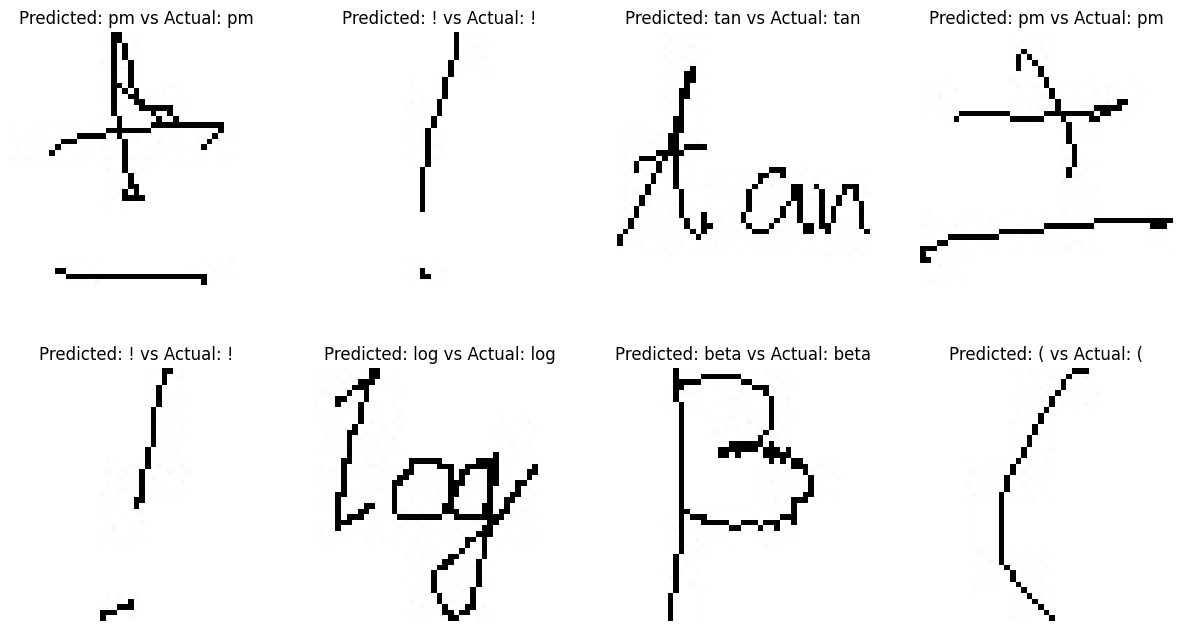

In [40]:
# True classification results
display_results_ann(true_indices_ann)

2/2 [==============================] - 0s 7ms/step


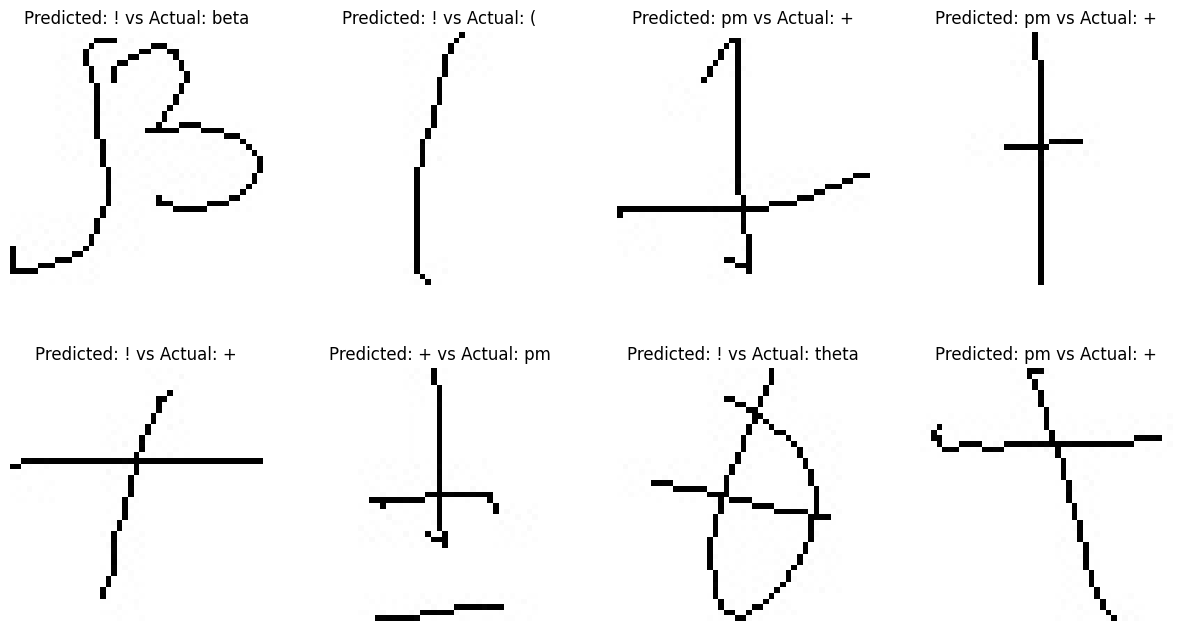

In [41]:
# Misclassification results
display_results_ann(misclassified_indices_ann)

# 6. References

[1] Chollet, F., & others. (2015). Keras. https://keras.io<br/>
[2] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org<br/>
[3] Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2. (Publisher link). <br/>
[4] Kingma, D. P., & Ba, J. (2017). Adam: A Method for Stochastic Optimization (arXiv:1412.6980). arXiv. http://arxiv.org/abs/1412.6980<br/>
[5] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., & Thirion, B. (2011).  Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825--2830.<br/>
[6] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453


# The end of the notebook